## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [6]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [7]:
#Se usa para obtener años del mismo largo, esto es necesario para el análisis posterior
dia_maximo = 365
year = '(2019)'
grupo_etario_list_titles=["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]

In [8]:
#filtra los datos asociados a causas respiratorias y agrega columas 
# que indican el año y el número de día correlativo
# adicionalmente se construye la tabla g1 que contiene los datos 
# correspodiente a las atenciones acumuladas del año
# hay un pequeño detalle con los años bisiestos
# esta parte solo funciona para un solo año

df2 = duckdb.sql("""
select
      fecha 
    , year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , sum(Menores_1) as Menores_1
    , sum(De_1_a_4) as De_1_a_4
    , sum(De_5_a_14) as De_5_a_14
    , sum(De_15_a_64) as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11) 
and year(strptime(fecha, '%d/%m/%Y')) in """ + year + """
and CodigoDependencia = 6
group by fecha, year, nrodia
having  nrodia <= """ + str(dia_maximo) + """
order by year, nrodia
""").df()
df2['fecha']= pd.to_datetime(df2['fecha'],format='%d/%m/%Y')
df2 = df2.sort_values(by='fecha').reset_index()
g1 = df2[["fecha","year","nrodia","Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]]

g1["acum_Menores_1"]=g1["Menores_1"].cumsum()
g1["acum_Menores_1"]=g1["acum_Menores_1"]/float(g1["acum_Menores_1"][[364]].iloc[0])
g1["acum_De_1_a_4"]=g1["De_1_a_4"].cumsum()
g1["acum_De_1_a_4"]=g1["acum_De_1_a_4"]/float(g1["acum_De_1_a_4"][[364]].iloc[0])
g1["acum_De_5_a_14"]=g1["De_5_a_14"].cumsum()
g1["acum_De_5_a_14"]=g1["acum_De_5_a_14"]/float(g1["acum_De_5_a_14"][[364]].iloc[0])
g1["acum_De_15_a_64"]=g1["De_15_a_64"].cumsum()
g1["acum_De_15_a_64"]=g1["acum_De_15_a_64"]/float(g1["acum_De_15_a_64"][[364]].iloc[0])
g1["acum_De_65_y_mas"]=g1["De_65_y_mas"].cumsum()
g1["acum_De_65_y_mas"]=g1["acum_De_65_y_mas"]/float(g1["acum_De_65_y_mas"][[364]].iloc[0])
g1["uniform"]=np.ones(365).cumsum()
g1["uniform"]=g1["uniform"]/float(g1["uniform"][[364]].iloc[0])

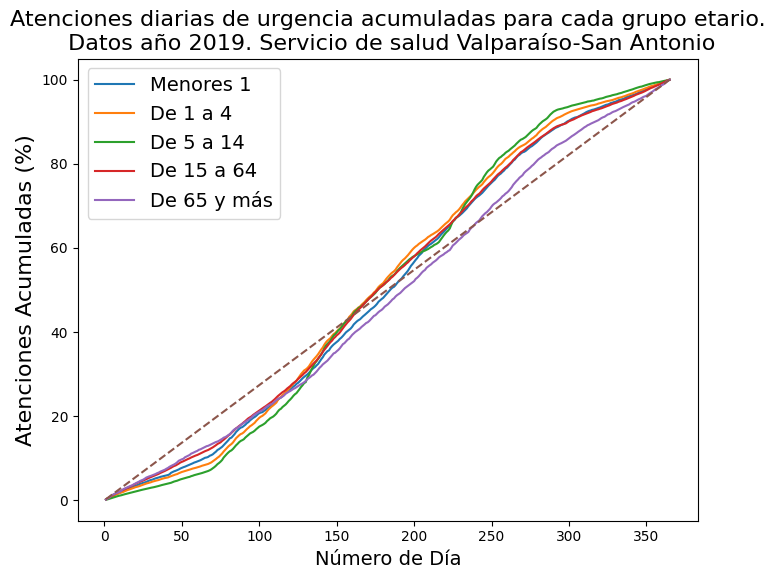

In [9]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
plt.plot(g1["nrodia"],100*g1[["acum_Menores_1","acum_De_1_a_4","acum_De_5_a_14","acum_De_15_a_64","acum_De_65_y_mas"]],
        label=["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"])
plt.plot(g1["nrodia"],100*g1["uniform"], linestyle='dashed')
plt.legend(grupo_etario_list_titles, fontsize = 14)
ax.set_title('Atenciones diarias de urgencia acumuladas para cada grupo etario.\n Datos año 2019. Servicio de salud Valparaíso-San Antonio', fontsize = 16)
ax.set_xlabel('Número de Día', fontsize = 14)
ax.set_ylabel('Atenciones Acumuladas (%)', fontsize = 16)

plt.savefig('fig5_atenciones_acumuladas_por_grupo_etario_2019.png', bbox_inches='tight')